In [1]:
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch

In [2]:
MODEL = "ddm"
RUN_SIMS = False
DEVICE = "cpu"

In [3]:
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = MODEL
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 256
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/"

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [7]:
generator_config["output_folder"] = (
    "data/lan_mlp/"
    + generator_config["model"]
    + "/"
    + str(generator_config["n_samples"])
    + "_"
    + str(generator_config["n_training_samples_by_parameter_set"])
    + "/"
)

In [8]:
if RUN_SIMS:
    n_datafiles = 20
    for i in range(n_datafiles):
        print("Datafile: ", i)
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
            generator_config=generator_config, model_config=model_config
        )
        training_data = my_dataset_generator.generate_data_training_uniform(save=True)

In [4]:
import pickle
folder_ = "../data/lan_mlp/" + MODEL + "/"
files_ = [folder_ + file_ for file_ in os.listdir(folder_)]

my_data = pickle.load(
    open(
        files_[0],
        "rb",
    )
)

In [5]:
from copy import deepcopy
network_config = deepcopy(lanfactory.config.network_configs.network_config_mlp)
network_config['layer_sizes'] = [100, 100, 100, 1]
network_config['activations'] = ['tanh', 'tanh', 'tanh', 'linear']

print("Network config: ")
print(network_config)

train_config = deepcopy(lanfactory.config.network_configs.train_config_mlp)
train_config['learning_rate'] = 0.000002

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 100, 1], 'activations': ['tanh', 'tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 2e-06, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [6]:
network_config

{'layer_sizes': [100, 100, 100, 1],
 'activations': ['tanh', 'tanh', 'tanh', 'linear'],
 'train_output_type': 'logprob'}

In [7]:
train_config["cpu_batch_size"] = 2048
train_config["gpu_batch_size"] = 2048
train_config["n_epochs"] = 20

In [8]:
train_config

{'cpu_batch_size': 2048,
 'gpu_batch_size': 2048,
 'n_epochs': 20,
 'optimizer': 'adam',
 'learning_rate': 2e-06,
 'lr_scheduler': 'reduce_on_plateau',
 'lr_scheduler_params': {},
 'weight_decay': 0.0,
 'loss': 'huber',
 'save_history': True}

In [9]:
folder_ = "../data/lan_mlp/" + MODEL + "/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)][:3]

# Training dataset
jax_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=train_config[DEVICE + "_batch_size"]
    if torch.cuda.is_available()
    else train_config[DEVICE + "_batch_size"],
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_training_dataloader = torch.utils.data.DataLoader(
    jax_training_dataset, shuffle=True, batch_size=None, num_workers=1, pin_memory=True
)

# Validation dataset
jax_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=train_config[DEVICE + "_batch_size"]
    if torch.cuda.is_available()
    else train_config[DEVICE + "_batch_size"],
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_validation_dataloader = torch.utils.data.DataLoader(
    jax_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

In [40]:
cnt = 0
for xb, yb in jax_training_dataloader:
    print(xb)
    print(yb)
    cnt += 1
    if cnt > 0:
        break

tensor([[ 0.1615,  1.2986,  0.7739,  1.6829, 11.5661,  1.0000],
        [-1.9381,  0.9173,  0.5608,  1.3857, 13.4255,  1.0000],
        [ 0.1582,  1.4980,  0.4946,  0.0658,  0.8469,  1.0000],
        ...,
        [ 0.7746,  2.2783,  0.8300,  1.8073,  2.9297,  1.0000],
        [ 2.5729,  0.5833,  0.5117,  0.8289,  1.1672,  1.0000],
        [-1.1318,  0.4758,  0.1894,  1.5282,  1.5557, -1.0000]])
tensor([[ -7.8343],
        [-23.0259],
        [ -1.3757],
        ...,
        [ -1.2525],
        [  0.0360],
        [  2.3369]])


In [10]:
# LOAD NETWORK
jax_net = lanfactory.trainers.MLPJaxFactory(network_config=network_config, train=True)
pickle.dump(network_config, open("../data/jax_models/" + MODEL + "/jax_network_config.pickle", 'wb'))

In [11]:
jax_trainer = lanfactory.trainers.ModelTrainerJaxMLP(
    train_config=train_config,
    model=jax_net,
    train_dl=jax_training_dataloader,
    valid_dl=jax_validation_dataloader,
    pin_memory=True,
)

In [12]:
train_state = jax_trainer.train_and_evaluate(
    output_folder="../data/jax_models/" + MODEL + "/",
    output_file_id=MODEL,
    run_id="test_run_notebook",
    wandb_on=False,
    wandb_project_id="test_run_notebook",
    save_data_details=True,
    verbose=1,
    save_all=True,
)

Found folder:  ..
Moving on...
Found folder:  ../data
Moving on...
Found folder:  ../data/jax_models
Moving on...
Found folder:  ../data/jax_models/ddm
Moving on...
Epoch: 0 of 20
Training - Step: 0 of 14646 - Loss: 4.6657476
Training - Step: 1000 of 14646 - Loss: 0.23539262
Training - Step: 2000 of 14646 - Loss: 0.13319452
Training - Step: 3000 of 14646 - Loss: 0.077041775
Training - Step: 4000 of 14646 - Loss: 0.084758
Training - Step: 5000 of 14646 - Loss: 0.061328642
Training - Step: 6000 of 14646 - Loss: 0.09372611
Training - Step: 7000 of 14646 - Loss: 0.10200088
Training - Step: 8000 of 14646 - Loss: 0.0922149
Training - Step: 9000 of 14646 - Loss: 0.08815187
Training - Step: 10000 of 14646 - Loss: 0.08820309
Training - Step: 11000 of 14646 - Loss: 0.09798707
Training - Step: 12000 of 14646 - Loss: 0.09019475
Training - Step: 13000 of 14646 - Loss: 0.07611063
Training - Step: 14000 of 14646 - Loss: 0.103473276
Epoch 0/20 time: 42.59603929519653s
Validation - Step: 0 of 14646 - L

In [13]:
# Loaded Net
jax_infer = lanfactory.trainers.MLPJaxFactory(
    network_config="../data/jax_models/" + MODEL + "/" + MODEL + "_jax_network_config.pickle",
    train=False,
)

In [14]:
forward_pass, forward_pass_jitted = jax_infer.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state="../data/jax_models/" + MODEL + "/test_run_notebook_lan_ddm__train_state.jax",
    add_jitted=True,
)

passing through identity


In [36]:
import jax.numpy as jnp

# Test parameters:
theta = deepcopy(ssms.config.model_config[MODEL]['default_params'])

theta[0] = 0.2
theta[3] = 1.0

# Comparison simulator run
sim_out = ssms.basic_simulators.simulator.simulator(
    model=MODEL, theta=theta, n_samples=50000
)

# Make input metric
input_mat = jnp.zeros((2000, len(theta) + 2))
for i in range(len(theta)):
    input_mat = input_mat.at[:, i].set(jnp.ones(2000) * theta[i])

input_mat = input_mat.at[:, len(theta)].set(
    jnp.array(
        np.concatenate(
            [
                np.linspace(5, 0, 1000).astype(np.float32),
                np.linspace(0, 5, 1000).astype(np.float32),
            ]
        )
    )
)
input_mat = input_mat.at[:, len(theta) + 1].set(
    jnp.array(
        np.concatenate([np.repeat(-1.0, 1000), np.repeat(1.0, 1000)]).astype(np.float32)
    )
)

net_out = forward_pass_jitted(input_mat)

(array([1.07477757e-04, 2.14955515e-04, 1.07477757e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.44866544e-04, 4.29911029e-04,
        6.44866544e-04, 6.44866544e-04, 6.44866544e-04, 8.59822058e-04,
        9.67299815e-04, 1.50468860e-03, 1.50468860e-03, 2.25703290e-03,
        3.22433272e-03, 2.57946617e-03, 4.83649908e-03, 4.62154356e-03,
        8.16830955e-03, 8.16830955e-03, 9.99543142e-03, 1.33272419e-02,
        1.79487855e-02, 2.28927623e-02, 2.90189945e-02, 3.49302711e-02,
        4.37434472e-02, 5.45987007e-02, 7.39446970e-02, 8.72719389e-02,
        1.13711467e-01, 1.40903340e-01, 1.71104590e-01, 2.14418126e-01,
        2.61385906e-01, 3.31676359e-01, 3.45433512e-01, 1.28328442e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.53048326e-01,
        5.10089436e-01, 4.96224805e-01, 4.30878329e-01, 3.279146

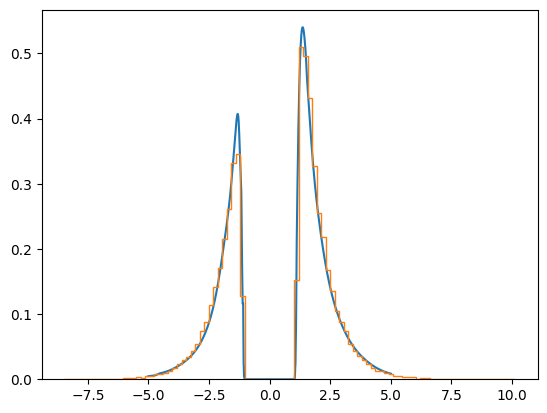

In [37]:
from matplotlib import pyplot as plt

plt.plot(np.linspace(-5, 5, 2000).astype(np.float32), np.exp(net_out))

plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    fill=None,
    density=True,
)